# Introduction

### Table of Contents
* [Set Up Environment](#set-up-environment)
* [The Test Image](#the-test-image)
* [The "Application"](#the-application)
* [Black-Box Classifier](#black-box-classifier)
* [MC-RISE Black-Box Saliency Algorithm](#drise-black-box-saliency-algorithm)
* [Rung the "Application"](#run-the-application)

### Miscellaneous
License for test image used may be found in 'COCO-LICENSE.txt'.

#### References
1. Hatakeyama, Y., Sakuma, H., Konishi, Y., & Suenaga, K. (2020). Visualizing color-wise saliency of black-box image classification models. In Proceedings of the Asian Conference on Computer Vision.


# Set Up Environment
**Note for Colab users**: after setting up the environment, you may need to "Restart Runtime" in order to resolve package version conflicts (see the [README](https://github.com/XAITK/xaitk-saliency/blob/master/examples/README.md#run-the-notebooks-from-colab) for more info).

In [1]:
import sys
!{sys.executable} -m pip install -qU pip
!{sys.executable} -m pip install -q xaitk-saliency
!{sys.executable} -m pip install -q "torch>=1.9.0"
!{sys.executable} -m pip install -q "torchvision>=0.10.0"

# The Test Image
We will test this application on the following image.
We know that this image contains the ImageNet class of "street sign".

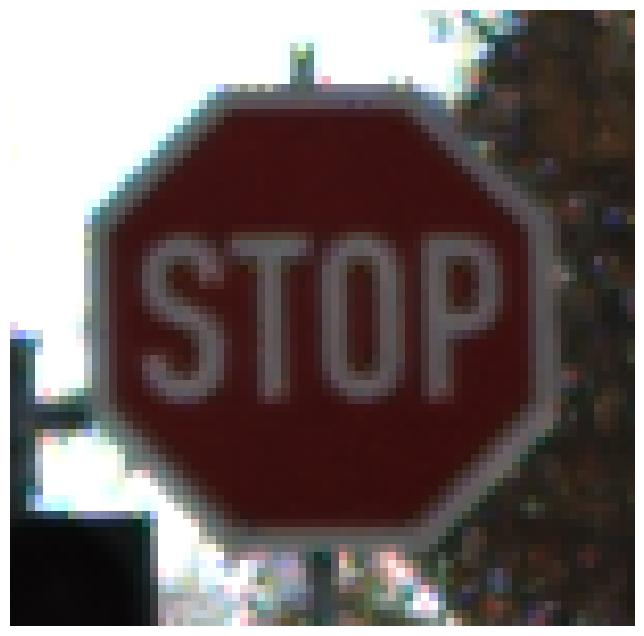

In [2]:
import os
import PIL.Image
import matplotlib.pyplot as plt
import urllib.request


# Use JPEG format for inline visualizations here.
%config InlineBackend.figure_format = "jpeg"

test_image_filename = 'data/02230.png'
plt.figure(figsize=(12, 8))
plt.axis('off')
_ = plt.imshow(PIL.Image.open(test_image_filename))

# The "Application"
The xaitk-saliency package provides a relatively high-level API interface for visual saliency map generation.
This interface defines the following input requirements:
  * a reference image
  * a black-box classifier that performs inference over images

As mentioned above, our high-level API accepts black-box classifiers in terms of the `ClassifyImage` interface.

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import PIL.Image
from smqtk_classifier import ClassifyImage
from xaitk_saliency import GenerateImageClassifierBlackboxSaliency
from typing import Dict, List


def app(
    image_filepath: str,
    # Assuming outputs `nClass` length arrays.
    blackbox_classify: ClassifyImage,
    gen_bb_sal: GenerateImageClassifierBlackboxSaliency,
):
    colors = {
        "red": [255, 0, 0],
        "green": [0, 255, 0],
        "blue": [0, 0, 255],
        "black": [0, 0, 0],
        "white": [255, 255, 255],
    }

    # Load the image
    ref_image = np.asarray(PIL.Image.open(image_filepath))

    sal_maps = []
    for color, c_value in colors.items():
        blackbox_fill = np.uint8(np.multiply(np.asarray(model_mean), np.asarray(c_value)))
        gen_rise_debiased.fill = blackbox_fill
        
        sal_maps.append(gen_bb_sal(ref_image, blackbox_classify))
    print(f"Saliency maps: {sal_maps[0].shape}")
    visualize_saliency(ref_image, sal_maps, colors)

def visualize_saliency(ref_image: np.ndarray, sal_maps: List[np.ndarray], colors: Dict[str, List[int]]) -> None:
    # Visualize the saliency heat-maps
    plt.figure(figsize=(3, 3))
    plt.imshow(ref_image)
    plt.axis('off')
    plt.title('Test Image')
    plt.show()
    
    sub_plot_ind = sal_maps[0].shape[0]
    plt.figure(figsize=(20, 8*sub_plot_ind))

    # Some magic numbers here to get colorbar to be roughly the same height
    # as the plotted image.
    colorbar_kwargs = {
        "fraction": 0.046*(ref_image.shape[0]/ref_image.shape[1]),
        "pad": 0.04,
    }

    for i in range(sal_maps[0].shape[0]):
        for c_idx, c_info in enumerate(colors.items()):
            c_name, c_value = c_info
            class_sal_map = sal_maps[c_idx][i, :, :]
            n_colors = len(colors)
            print(f"Class {i} {c_name} saliency map range: [{class_sal_map.min()}, {class_sal_map.max()}]")

            # Positive half saliency
            plt.subplot(2*sub_plot_ind, n_colors, (i*2)*n_colors+c_idx+1)
            plt.imshow(ref_image, alpha=0.7)
            plt.imshow(
                np.clip(class_sal_map, 0, 1),
                cmap='Reds', alpha=0.5
            )
            plt.clim(0, 1)
            plt.colorbar(**colorbar_kwargs)
            plt.title(f"Class #{i+1} +ve sal ({c_name})")
            plt.axis('off')

            # Negative half saliency
            plt.subplot(2*sub_plot_ind, n_colors, (i*2+1)*n_colors+c_idx+1)
            plt.imshow(ref_image, alpha=0.7)
            plt.imshow(
                np.clip(class_sal_map, -1, 0),
                cmap='Blues_r', alpha=0.5
            )
            plt.clim(-1, 0)
            plt.colorbar(**colorbar_kwargs)
            plt.title(f"Class #{i+1} -ve sal ({c_name})")
            plt.axis('off')

# Black-Box Classifier
In this example, we will use a basic PyTorch-based, pretrained ResNet34 model and use its softmax output as classification confidences.
Since this model normally outputs 1000 classes, we will, for simplicity of example, constrain the output to the class that is relevant for our test image.

In [4]:
# Set up our "black box" classifier using PyTorch and it's ImageNet pretrained ResNet34.
# We will constrain the output of our classifier here to the class that is relevant
# to our test image for the purposes of this example.
import torch
from torch.utils.data import DataLoader, Dataset
import torchvision.models as models
import torchvision.transforms as transforms

CUDA_AVAILABLE = torch.cuda.is_available()


model = models.resnet34(pretrained=True)
model = model.eval()
if CUDA_AVAILABLE:
    model = model.cuda()

# These are some simple helper functions to perform prediction with this model
model_input_size = (224, 224)
model_mean = [0.485, 0.456, 0.406]
model_loader = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize(model_input_size),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=model_mean,
        std=[0.229, 0.224, 0.225]
    ),
])


# Grabbing the class labels associated with this model.
classes_file = "data/imagenet_classes.txt"
if not os.path.isfile(classes_file):
    !wget https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt -O {classes_file}

f = open(classes_file, "r")
categories = [s.strip() for s in f.readlines()]


# For this test, we will use an image with a street sign in it.
# Let's only consider the saliency of that class' predictions.
sal_class_labels = ['street sign']
sal_class_idxs = [categories.index(lbl) for lbl in sal_class_labels]


class TorchResnet34 (ClassifyImage):
    """ Blackbox model to output the two focus classes. """

    def get_labels(self):
        return sal_class_labels

    @torch.no_grad()
    def classify_images(self, image_iter):
        # Input may either be an NDaray, or some arbitrary iterable of NDarray images.

        for img in image_iter:
            image_tensor = model_loader(img).unsqueeze(0)
            if CUDA_AVAILABLE:
                image_tensor = image_tensor.cuda()
            feature_vec = model(image_tensor)
            # Converting feature extractor output to probabilities.
            class_conf = torch.nn.functional.softmax(feature_vec, dim=1).cpu().detach().numpy().squeeze()
            # Only return the confidences for the focus classes
            yield dict(zip(sal_class_labels, class_conf[sal_class_idxs]))

    def get_config(self):
        # Required by a parent class.
        return {}


blackbox_classifier = TorchResnet34()

/home/local/KHQ/emily.veenhuis/Documents/cdao/xaitk-jatic/venv/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/local/KHQ/emily.veenhuis/Documents/cdao/xaitk-jatic/venv/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


# MC-RISE Black-Box Saliency Algorithm

In [5]:
from xaitk_saliency import GenerateClassifierConfidenceSaliency
from xaitk_saliency.utils.masking import weight_regions_by_scalar
from sklearn.preprocessing import maxabs_scale
from typing import Any

class MCRISEScoring (GenerateClassifierConfidenceSaliency):
    def __init__(
        self,
        k: int,
        p1: float = 0.0,
    ):
        if p1 < 0 or p1 > 1:
            raise ValueError(
                f"Input p1 value of {p1} is not within the expected [0,1] "
                f"range."
            )
        self.p1 = p1

        if k < 1:
            raise ValueError(
                f"Input k value of {k} is not withing the expected >0 range."
            )
        self.k = k

    def generate(
        self,
        image_conf: np.ndarray,
        perturbed_conf: np.ndarray,
        perturbed_masks: np.ndarray,
    ) -> np.ndarray:
        if len(perturbed_conf) != len(perturbed_masks):
            raise ValueError("Number of perturbation masks and respective "
                             "confidence lengths do not match.")

        # Debias based on the MC-RISE paper 
        sal = weight_regions_by_scalar(
            perturbed_conf,
            perturbed_masks*(1 - self.p1 + self.p1/self.k) - self.p1/self.k,
            inv_masks=False,
            normalize=False
        )

        # Normalize final saliency map
        sal = maxabs_scale(
            sal.reshape(sal.shape[0], -1),
            axis=1
        ).reshape(sal.shape)

        # Ensure saliency map in range [-1, 1]
        sal = np.clip(sal, -1, 1)

        return sal
    
    def get_config(self) -> Dict[str, Any]:
        return {
            "p1": self.p1,
            "k": self.k,
        }

In [6]:
from typing import Any, Dict, Optional, Sequence, Union
from xaitk_saliency.impls.perturb_image.rise import RISEGrid
from xaitk_saliency.impls.gen_image_classifier_blackbox_sal.occlusion_based import PerturbationOcclusion
from xaitk_saliency.impls.gen_classifier_conf_sal.rise_scoring import RISEScoring

class MCRISEStack (GenerateImageClassifierBlackboxSaliency):
    """
    Encapsulation of the perturbation-occlusion method using specifically the
    MC-RISE implementations of the component algorithms.

    This more specifically encapsulates the MC-RISE method as presented
    in their paper and code. See references in the :class:`RISEGrid`
    and :class:`RISEScoring` documentation.

    This implementation shares the `p1` probability and 'k' number colors
    with the internal `RISEScoring` instance use, to make use of the
    debiasing described in the MC-RISE paper. Debiasing is always on.

    :param n:
        Number of random masks used in the algorithm. E.g. 1000.
    :param s:
        Spatial resolution of the small masking grid. E.g. 8.
        Assumes square grid.
    :param p1:
        Probability of the grid cell being set to 1 (otherwise 0).
        This should be a float value in the [0, 1] range. E.g. 0.5.
    :param k:
        The number of different fill colors to be used when generating masks.
    :param seed:
        A seed to pass into the constructed random number generator to allow
        for reproducibility
    :param threads: The number of threads to utilize when generating masks.
        If this is <=0 or None, no threading is used and processing
        is performed in-line serially.
    """
        
    def __init__(
        self,
        n: int,
        s: int,
        p1: float,
        k: int,
        seed: Optional[int] = None,
        threads: int = 0,
    ):
        self._k = k
        self._po = PerturbationOcclusion(
            RISEGrid(n=n, s=s, p1=p1, seed=seed, threads=threads),
            MCRISEScoring(k=k, p1=p1),
            threads=threads
        )

    @property
    def fill(self) -> Optional[Union[int, Sequence[int]]]:
        return self._po.fill

    @fill.setter
    def fill(self, v: Optional[Union[int, Sequence[int]]]) -> None:
        self._po.fill = v

    def _generate(self, ref_image: np.ndarray, blackbox: ClassifyImage) -> np.ndarray:
        return self._po.generate(ref_image, blackbox)

    def get_config(self) -> Dict[str, Any]:
        c = self._po._perturber.get_config()
        c['k'] = self._k
        return c

In [7]:
gen_rise_debiased = MCRISEStack(1000, 8, 0.5, k=5, seed=0, threads=4)

# Run the "Application"

Saliency maps: (1, 75, 76)


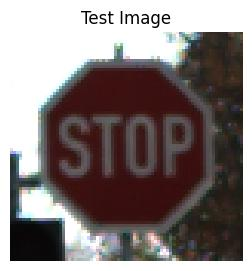

Class 0 red saliency map range: [0.5879062414169312, 1.0]
Class 0 green saliency map range: [0.4748556911945343, 1.0]
Class 0 blue saliency map range: [0.5746527910232544, 1.0]
Class 0 black saliency map range: [0.6954065561294556, 1.0]
Class 0 white saliency map range: [0.555267333984375, 1.0]


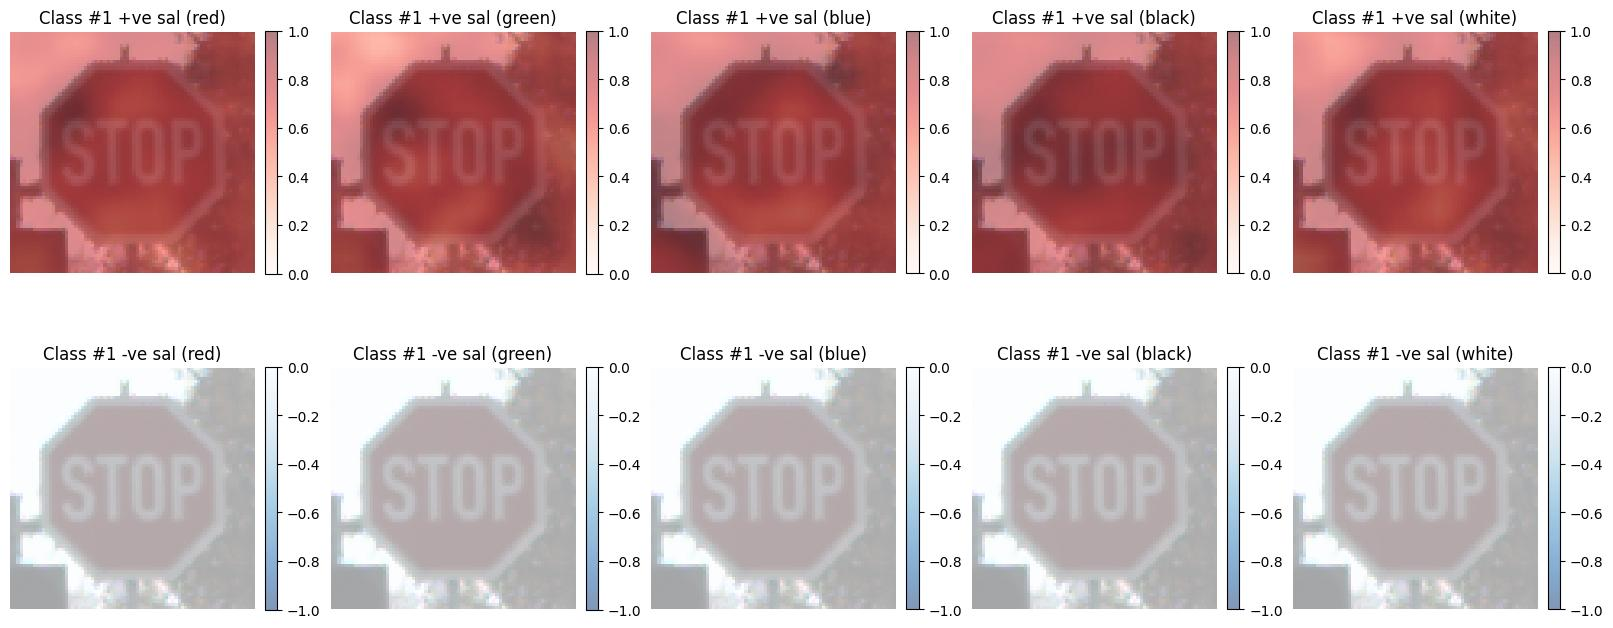

In [8]:
app(
    test_image_filename,
    blackbox_classifier,
    gen_rise_debiased,
)